# Bean Classification Project Proposal 

In [ ]:
install.packages("cowplot")
install.packages("kknn")
library(kknn)

In [ ]:
#import libraries
install.packages("themis")
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 16)
library(readxl)
library(ggplot2)
library(cowplot)

In [ ]:
library(themis)

# Introduction

This data set was extracted from the article written by Kolku and Ozkan, “Multiclass classification of dry beans using computer vision and machine learning techniques” (2020). Koluk and Ozkan (2020) explore the use of computer vision and machine learning techniques to classify dry beans into different classes. The goal of the study was to use machine learning algorithms to accurately classify the dry beans into their respective varieties based on the extracted features. This study is relevant for the food industry and agriculture, as it can potentially help in automating the classification process of dry beans, which is currently done manually and is time-consuming.

**Research Question**: Can we accurately predict the bean type in an image based on the predictors Area and Roundness?

This dataset is based on 13611 images of 7 types of individual dry beans with similar features. Each image was analyzed for 16 features of the bean (4 "shape factors", 12 structural/geometric features) (Kolku & Ozkan, 2020). While the dataset use up to 12 predictors to classify the data points, we will try to reduce the number of the predictor and see if the accuracy of the estimate still has high or nearly has high.

We will be using the K-nearest neighbours classification to predict "Class" using the mentioned predictors. K-nearest neighbours find the K-closest data points to the input sample and assign the most common class label among them. The accuracy of the model can be improved by tuning the value of K.


Our variable of intetrest (Kolku & Ozkan, 2020).:
- **Area**:The area of a bean zone and the number of pixels within its boundaries.
- **Roundness**: Calculated with the following formula: (4piA)/(P^2). Where A is the area and P is the perimeter of the bean

# Methods

**Load Data**: A zip file was loaded from the original web source (https). Then, we create a temporary file path to store the 'temp' variable, to temporarily store the downloaded zip file before it is extracted. Next, we use 'download.fil' to download the zip file and save it in 'temp'. The unzip() function extracts the xlsx file from the downloaded zip file and saves it in the 'beanzip' filepath. Finally, the read_excel file reads the xlsx file and we named our the data frame 'bean'. 


In [ ]:
beanurl<-"https://archive.ics.uci.edu/ml/machine-learning-databases/00602/DryBeanDataset.zip"
temp <- tempfile()
download.file(beanurl,temp)
beanzip <- unzip(temp, "DryBeanDataset/Dry_Bean_Dataset.xlsx")
bean <- read_excel(beanzip)
bean

*Table 1: Raw Bean dataset*

**Select variables & data wrangling & cleaning**: After exploring the data and doing research, we will select two variables for prediction: roundness and area. According to a study published in the Journal of Food Engineering (2012), area and roundness were among the most important features for accurate classification (Rahman et al., 2012). Also, these two variable produce distinct clusters by bean type, which is helpful in classifying the datapoints (as seen later on in *Figure 1*).

In [ ]:
select_bean_var <- bean |>
                select("Area","roundness","Class")
select_bean_var 

*Table 2: Bean data frame with chosen variable*

**Visualize plot**: all of the bean types, in relation to roundness and area, are plotted on the graph. 

In [ ]:
bean_plot <- select_bean_var |>
  ggplot(aes(x = Area, y = roundness, color = Class)) +
  geom_point(size = 0.2) +
  labs(x = "Area", 
       y = "Roundness",
       color = "Type") +
  ggtitle("Figure 1: Area and Roundness of all bean type")+
  theme(text = element_text(size = 12))
bean_plot

As shown in Figure 1, Barbunya has a lack of clustering that causes too many overlaps. This may result in an inaccurate model. Thus, we will remove the Class Barbunva. which will enable the KNN model to better distinguish between the remaining classes, ultimately improving the overall accuracy of the model. The "Class" column was also converted to a factor type for this classification model. 

In [ ]:
select_bean <- select_bean_var|>
                filter(Class != "BARBUNYA")|>
                mutate(Class = as.factor(Class))
select_bean

*Table 3: Bean dataframe with Barbunya filtered out*

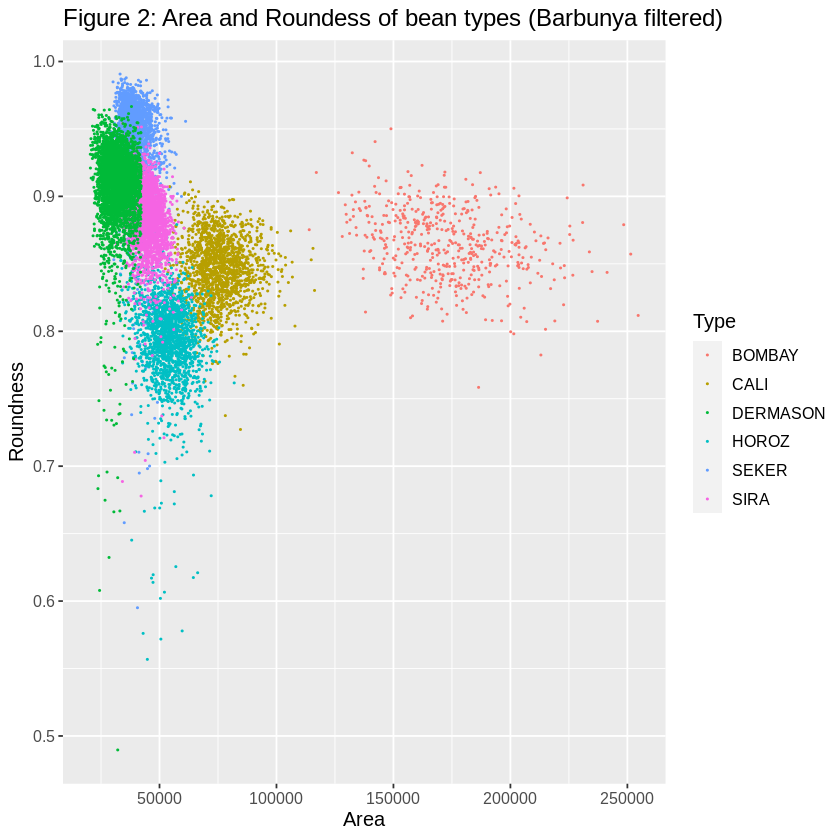

In [8]:
bean_plot2 <- select_bean |>
  ggplot(aes(x = Area, y = roundness, color = Class)) +
  geom_point(size = 0.2) +
  labs(x = "Area", 
       y = "Roundness",
       color = "Type") +
  ggtitle("Figure 2: Area and Roundess of bean types (Barbunya filtered)")+
  theme(text = element_text(size = 12))
bean_plot2

We graph it again, and we can see that the clusters in Figure 2 are more clean.

In [9]:
##Creating training and testing dataset

set.seed(2022)
bean_split <- initial_split(select_bean, prop = 0.75, strata = Class)
bean_train <- training(bean_split)
bean_test <- testing(bean_split)

Graphing the training dataset in plot point

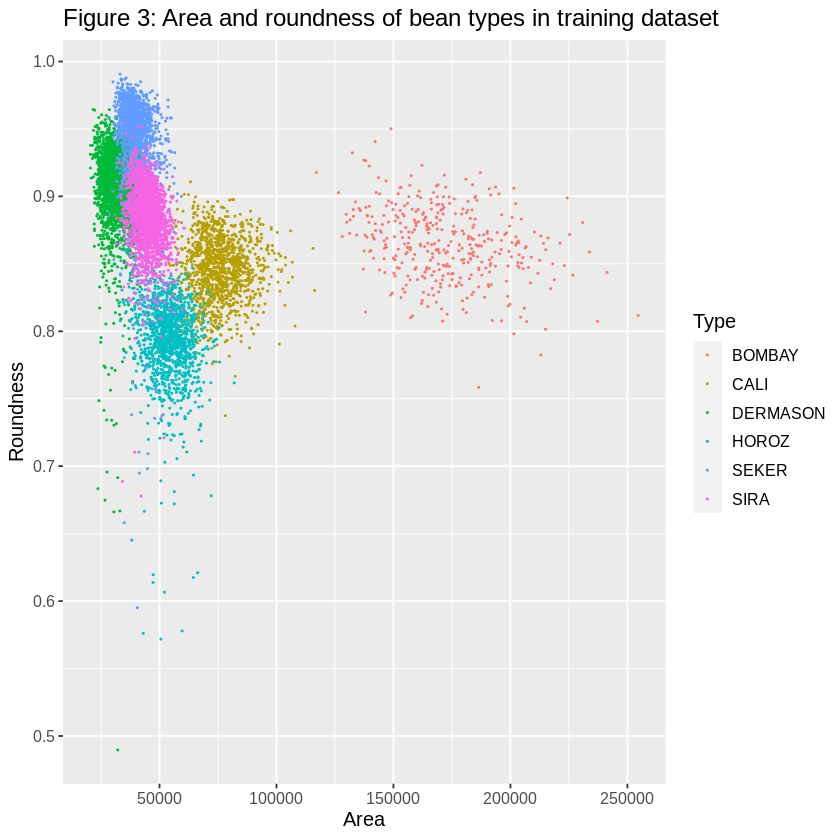

In [10]:
area_round_plot <- bean_train |>
  ggplot(aes(x = Area, y = roundness, color = Class)) +
  geom_point(size = 0.2) +
  labs(x = "Area", 
       y = "Roundness",
       color = "Type") +
  ggtitle("Figure 3: Area and roundness of bean types in training dataset")+
  theme(text = element_text(size = 12))
area_round_plot

From Figure 3, we can see that there are big difference between area value and the roundness value, therefore, we will scale the data, which will be dealt with in `workflow()` .

In [11]:
#Summarize training dataset
bean_class_dist <- bean_train |>
                group_by(Class)|>
                summarize(count = n()) |>
                mutate(percentage_dist = 100*count/nrow(bean_train))
bean_class_dist

Class,count,percentage_dist
<fct>,<int>,<dbl>
BOMBAY,380,4.123711
CALI,1222,13.260988
DERMASON,2667,28.941942
HOROZ,1447,15.702659
SEKER,1524,16.538253
SIRA,1975,21.432447


*Table 4: Distribution of bean types in training set*

The table, and bar chart show us the distribution of bean types in the training set

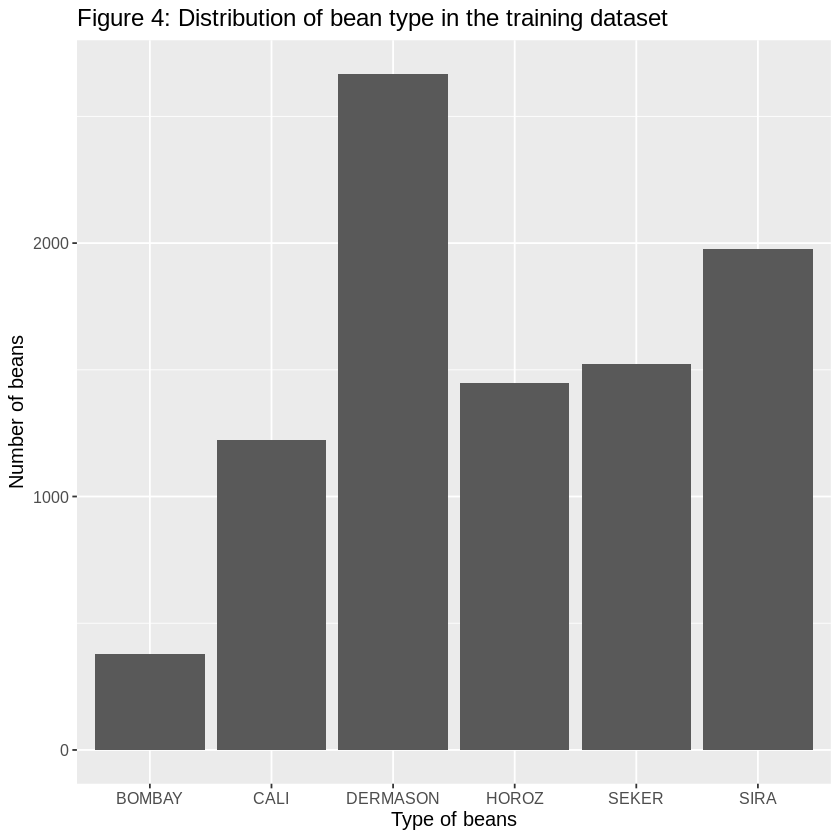

In [12]:
bean_class_dist_plot <- bean_class_dist |>
                        ggplot(aes(x=Class, y = count))+
                        geom_bar(stat = "identity")+
                        labs(x= "Type of beans",
                             y = "Number of beans")+
                        ggtitle("Figure 4: Distribution of bean type in the training dataset")+
                        theme(text = element_text(size = 12))
bean_class_dist_plot

**Upsampling**: By looking at the Table 3, and Figure 4 viewing the total number of datapoints for each type of beans, we can see that there are a big difference in number of datapoints between Dermason bean type with other type of beans. Therefore, we will upsample the training dataset so that each Class of bean has a voting power when it comes to the classfication of the testing dataset.

**Scaling:** all data is called to avoid features with large values dominating the decision process. The Scaling of the data later be part of the Classifier building process called `workflow()`

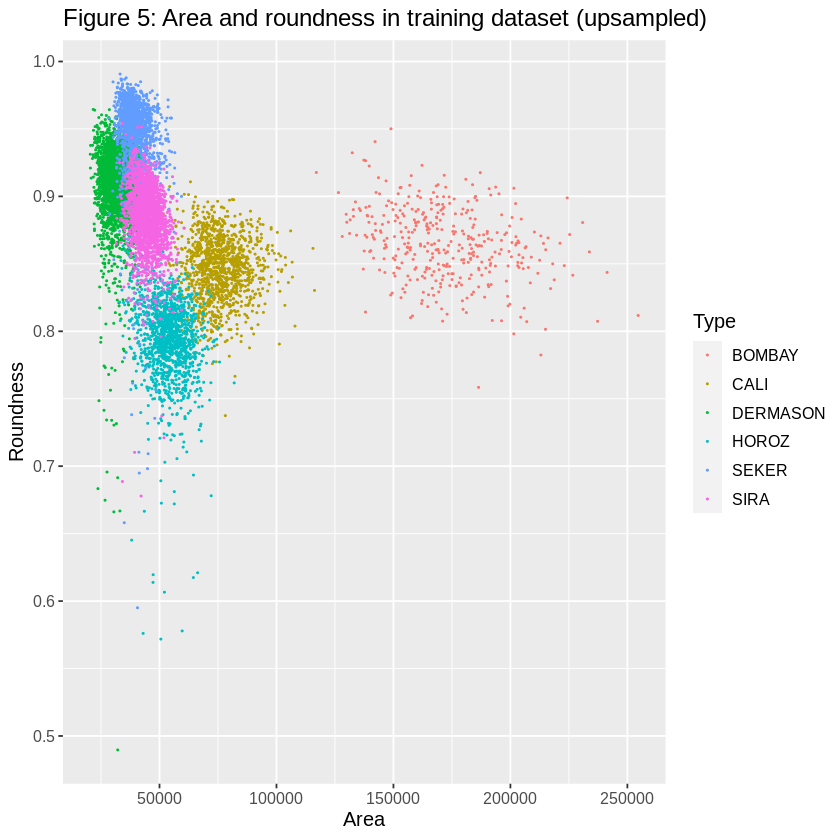

In [13]:
## Scalling all data:

bean_data_training_scaled_recipe <- recipe(Class ~., data = bean_train) |>
                        step_upsample()|>
                        prep()

final_bean_data <- bake(bean_data_training_scaled_recipe, bean_train)

area_round_plot_scaled <- final_bean_data |>
  ggplot(aes(x = Area, y = roundness, color = Class)) +
  geom_point(size = 0.2) +
  labs(x = "Area", 
       y = "Roundness",
       color = "Type") +
  ggtitle("Figure 5: Area and roundness in training dataset (upsampled)")+
  theme(text = element_text(size = 12))
area_round_plot_scaled

Summary of the data set: Next we will look at Statistical distribution of our chosen variables, in table and boxplot form. We calculated the basic statistics such as range and standard deviation for each feature, as well as determining the distribution. 


In [14]:
#Statistical Distribution of predictor based on class
features_dist_by_class <- final_bean_data |>
                group_by(Class)|>
                summarize(max_area = max(Area, na.rm = TRUE),
                          min_area = min(Area, na.rm = TRUE),
                          std_dev_area = sd(Area, na.rm = TRUE),
                          max_roundness = max(roundness, na.rm = TRUE),
                          min_roundness = min(roundness, na.rm = TRUE),
                         std_dev_roundness = sd(roundness, na.rm = TRUE))
features_dist_by_class

Class,max_area,min_area,std_dev_area,max_roundness,min_roundness,std_dev_roundness
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BOMBAY,254616,117034,22827.238,0.9501045,0.7584168,0.02733660
CALI,116272,45504,9417.061,0.9107939,0.7374636,0.02318165
DERMASON,42159,20420,4670.699,0.9666028,0.4896183,0.02917184
HOROZ,81929,33006,7381.962,0.9190136,0.5718009,0.03143601
SEKER,59385,28395,4814.962,0.9906854,0.5950484,0.03290233
SIRA,60493,31519,4543.983,0.9541042,0.6778369,0.02382635


*Table 5: Statistical distribution of each predictor based on their class*

In [15]:
#Statistical Distribution in Features of varieties of dry bean
features_dist <- bean_train |>
            select(Area,roundness) |>
            pivot_longer(cols= Area:roundness,
                         names_to = "Features",
                         values_to = "values") |>
            group_by(Features) |>
            summarize(Mean = mean(values, na.rm = TRUE),
                      Min = min(values, na.rm = TRUE),
                      Max = max(values, na.rm = TRUE),
                     Std_Deviation = sd(values, na.rm = TRUE))
features_dist

Features,Mean,Min,Max,Std_Deviation
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Area,5.108452e+04,2.042000e+04,2.546160e+05,2.964613e+04
roundness,8.813456e-01,4.896183e-01,9.906854e-01,5.496258e-02


*Table 6: Statistical distribution of the predictors in the whole dataset*

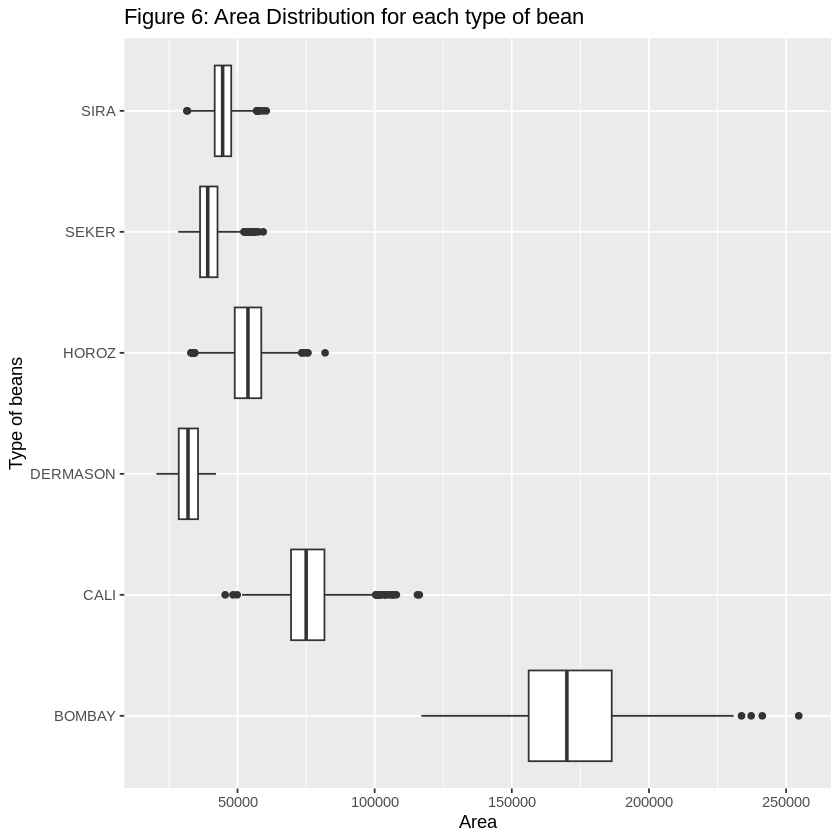

In [16]:
#Graphing area distribution for each type of bean
area_box_plot <- final_bean_data |>
                ggplot(aes(x = Class, y = Area))+
                geom_boxplot()+
                xlab("Type of beans")+
                ylab("Area")+
                ggtitle("Figure 6: Area Distribution for each type of bean")+
                coord_flip()
area_box_plot

By looking at Figure 5, we can find that the square box which represent 50% of each bean type has little overlap over each other (Krzywinski et al., 2014) . we can also find that 5/6 bean type (Sira, Seker, Horoz, Cali, and Bombay) has outliers that is higher than most of its usual area size, base on the dots above the upper whiskers (Krzywinski et al., 2014). We might expect that these outliers might also affect the accuracy of the classifier as these outliers starts overlapping over other bean types area measurements. However, out of all the bean type Bombay seems to have its distribution in area distinguished over other bean type, so we might see that the classifier can predict the Bombay bean type better than other type. While Sira and Seker area distribution seems to over over each other so we also expect that this can affect classifier accuracy.

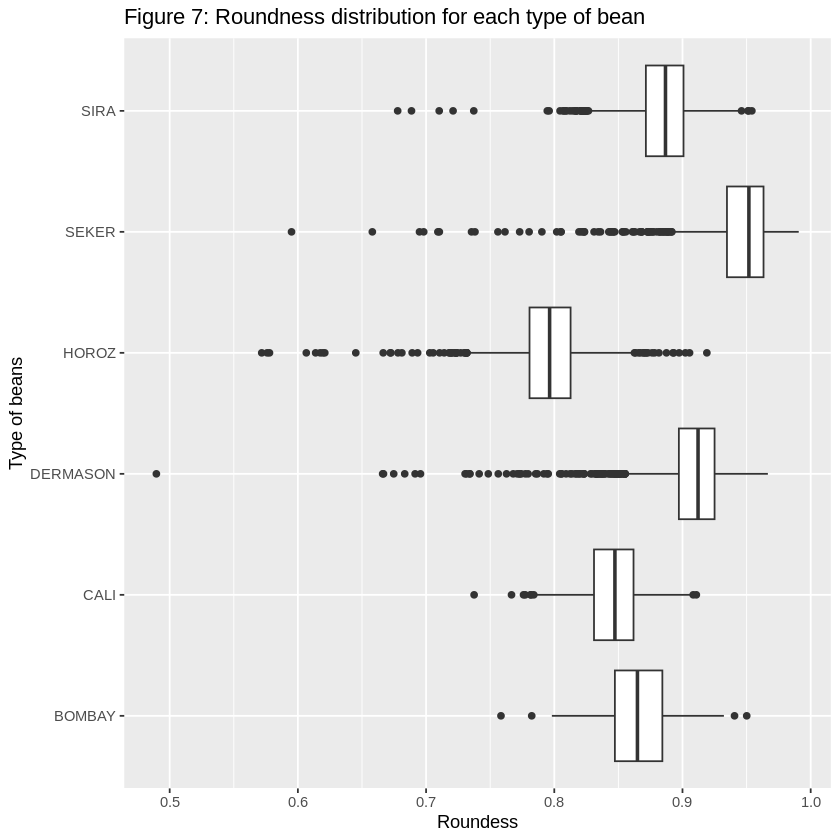

In [17]:
#Graphing box plot showing roundness distribution for each type of box plot
roundness_box_plot <- final_bean_data |>
                ggplot(aes(x = Class, y = roundness))+
                geom_boxplot()+
                xlab("Type of beans")+
                ylab("Roundess")+
                ggtitle("Figure 7: Roundness distribution for each type of bean")+
                coord_flip()
roundness_box_plot

In *Figure 7*, we can see that most of the bean type 50% of roundness distribution does not overlap each other. However there are a lot of outliers that cause these bean type roundness distribution to overlap each other. The overlap of roundness distribution of dataset matches the distribution of bean type of Area and Roundness that we see in Figure 1, 2, 3, 5. However, due to 50% of the dataset mostly don't overlap each other as we seen in *Figure 7*, we can also see distinct cluster in Figure 1,2, 3, and 5.

# Building the Classification Model

Now we should start building the classifier. However, before starting to build the classifier, we need to create the scaling and centering recipe on the training dataset, to ensure that all predictors are standardized, so that predictor with larger scales won't create a greater unwanted affect.

In [18]:
set.seed(2022) # DO NOT REMOVE

bean_report_recipe <- recipe(Class ~., data = final_bean_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
bean_report_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



Next, we need to tune our model using the cross-validation method, so that we can choose the optimal K-neighbour. First we need to specify the model for cross-validation, where the neighbour = tune() is used to test accuracies of model across different range of k-neighbours. Cross-validation is a method to help us tune our classifier. Cross-validation will randomly divide the training sets into specified number of smaller set with the same size. The method then will train our classifier using the remaining sets that were not accept as one test set. This process is repeated until all of the set that was divided has a chance to be a test set (Arlot and Celisse, 2010). Here we use cross-validation across a range of number of neighbours and get the number with the best accuracy estimate.

In [19]:
set.seed(2022) # DO NOT REMOVE

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

Now we use the `vfold_cv()` to split the training data into 10 fold for cross-validation. `gridvals` is where we set the range of k-neighbours that we would like to cross-validate with. Since we have run the this code a few time to get the best estimate of a range of k-neighbours to use, we decide only run upto 30 k-neighbours to get the best k-neighbours for our classifier.

In [20]:
set.seed(2022) # DO NOT REMOVE
bean_vfold <- vfold_cv(final_bean_data, v = 10, strata = Class)
gridvals <- tibble(neighbors = seq(1,30,by=1))

Now we start to cross-validate multiple k-neighbours to the training dataset. The function `tune_grid()` here allow us to fit the model for each value in a range of value. After the cross-validation is run, we collect the accuracie calculated from each value of k-neighbours.

In [21]:
set.seed(2022) # DO NOT REMOVE

knn_results <- workflow() |>
  add_recipe(bean_report_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = bean_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "accuracy")

Now we graph the k-neighbours against the mean accuracy calculated from cross-validated across 10 folds.

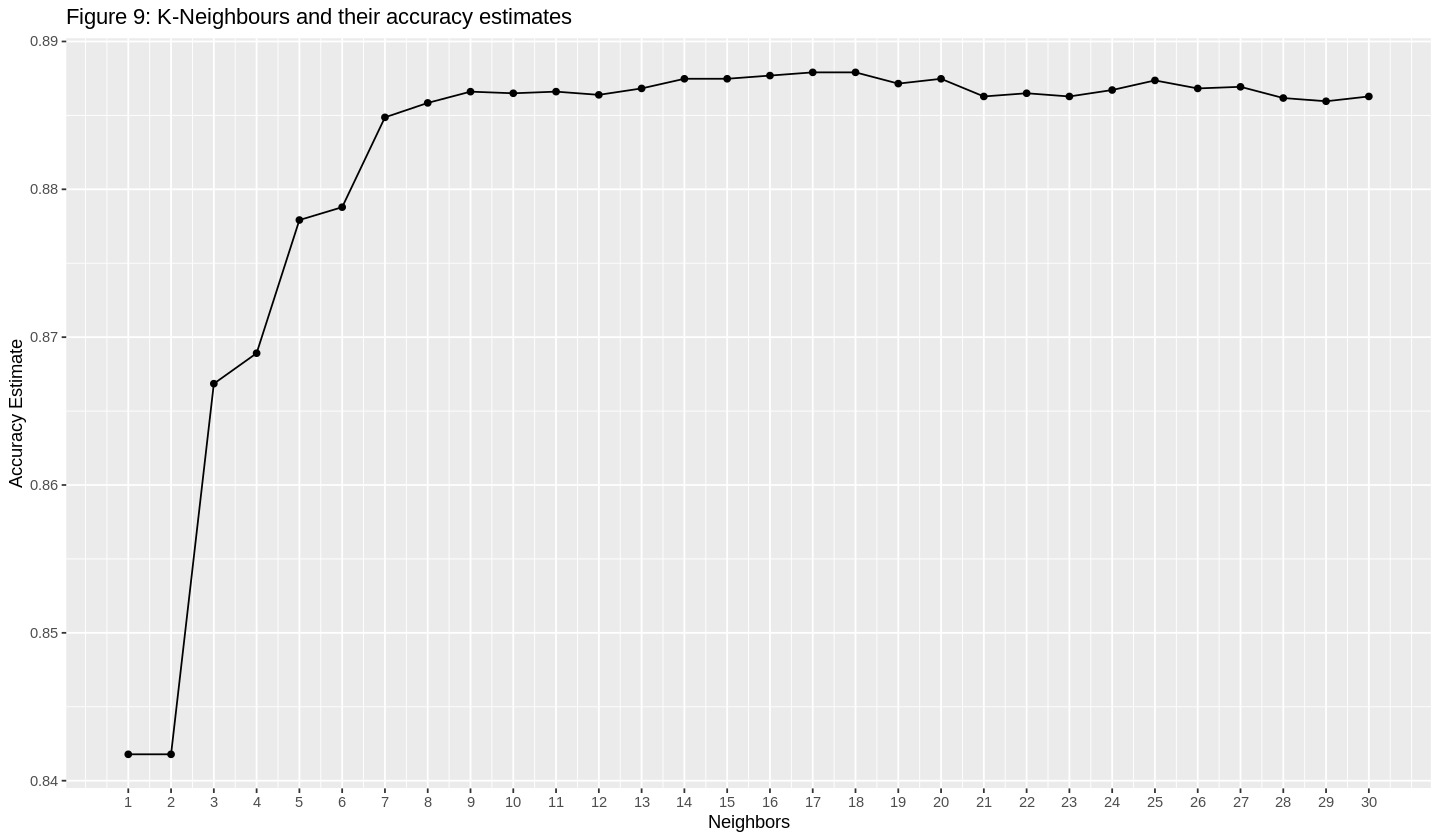

In [22]:
options(repr.plot.width = 12, repr.plot.height = 7)

# Plot k values against their respective accuracies and choose optimal k value
cross_val_plot <- knn_results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Figure 9: K-Neighbours and their accuracy estimates")+
    scale_x_continuous(breaks = seq(1,30, by = 1))
cross_val_plot

From *Figure 9*, we can see that with such a large dataset like the bean dataset, large number of neighbour is required to predict the data accurately. 
From the graph we can see that the highest accuracies is around 17-19 neighbours. And we see that around 18 neighbors is good since the 19 neighbours, and 17 neighbours, the accuracies aren't that much different from the 18 neighbours. 

**Visualizations of the analysis**: a confusion matrix is shown below to help interpret the results and communicate the findings effectively.


Now that we have a good estimate of which neighbours yield the highest accuracy for our classification, we should build our classifier with that k-neighbour, in our case is: 18 neighbour. We first build the specification of the classifier using the best neighbour. Then we build the workflow with the best spec, and we can use the recipe that we created before. 

In [34]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 18) |>
  set_engine("kknn") |>
  set_mode("classification")

bean_fit <- workflow() |>
  add_recipe(bean_report_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = final_bean_data)

Now we start using the new classifier that we just created to build predict our test dataset

In [35]:
# Get the prediction column
bean_predictions <- predict(bean_fit, bean_test) |> 
    bind_cols(bean_test)

Now we calculate the accuracy of the classifier by comparing the predictions to the test set

In [36]:
bean_acc <- bean_predictions |> 
    metrics(truth = Class, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)
bean_acc

.metric,.estimate
<chr>,<dbl>
accuracy,0.8812622


*Table 7: Accuracy estimate our model against the test set*

Now we build a confusion matrix that compare the prediction made to the truth values

In [37]:
bean_cm <- bean_predictions |> 
    conf_mat(truth = Class, estimate = .pred_class)
bean_cm

          Truth
Prediction BOMBAY CALI DERMASON HOROZ SEKER SIRA
  BOMBAY      141    0        0     0     0    0
  CALI          1  380        0     6     0    0
  DERMASON      0    0      781     3    68   73
  HOROZ         0   18        5   455     7   15
  SEKER         0    0       32     1   397   18
  SIRA          0   10       61    16    31  555

*Table 8: Confusion matrix of the predicted class and the truth class*

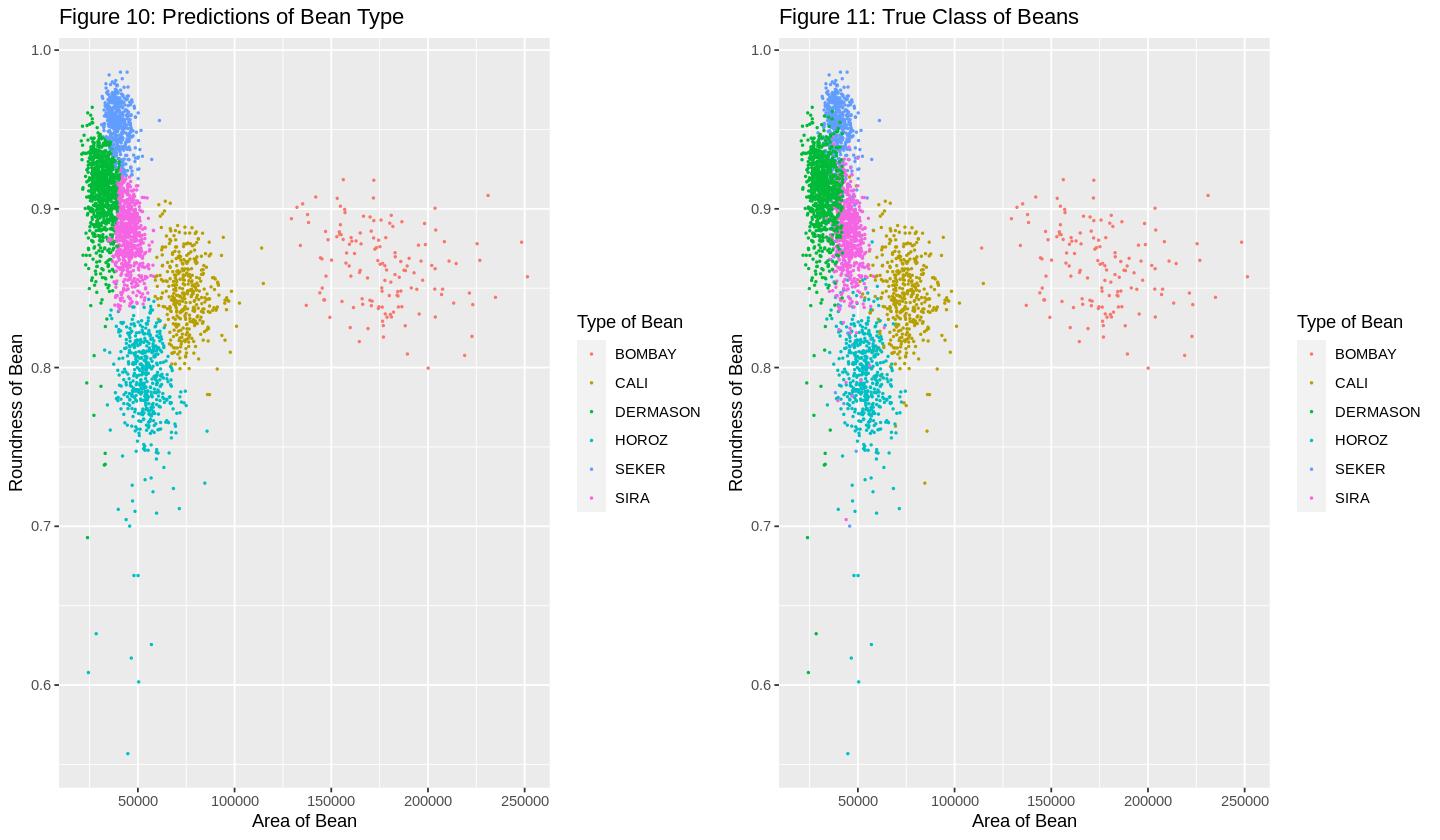

In [38]:
#visual comparison of true class vs predicted class

bean_predictions_plot <- bean_predictions |>
    ggplot(aes(x = Area, y = roundness, color = .pred_class)) +
    geom_point(size = 0.3) +
    labs(x = "Area of Bean", y = "Roundness of Bean", color = "Type of Bean") +
    ggtitle("Figure 10: Predictions of Bean Type")

bean_trueclass_plot <- bean_predictions |>
    ggplot(aes(x = Area, y = roundness, color = Class)) +
    geom_point(size = 0.3) +
    labs(x = "Area of Bean", y = "Roundness of Bean", color = "Type of Bean") +
    ggtitle("Figure 11: True Class of Beans")

plot_grid(bean_predictions_plot, bean_trueclass_plot, ncol = 2)

# Discussion

**Results**

With the help of a classification model, we expect to find a well-performing model that can predict the type of beans based on their roundness and area with at least 85% accuracy. From *Table 7*, the result of the k-nearest neighbors (k-NN) model shows an estimated accuracy of 0.8812622. This means that the model was able to correctly classify 88.13% of the beans in the dataset based on their area and roundness. This is a relatively high accuracy as the classes are similar in appearance and is difficult to differentiate based on these features alone. While this estimated accuracy is high, if we use all the predictor that was the proposed in the paper that the dataset was based on, the KNN algorithm will produce a classifier with a higher accuracy estimate (exactly 92.52% in the paper). 

Now looking at each individual class prediction, in *Table 8*, we can see that the classifier predicts the Bombay bean type correctly 100% of the time. While the classifier predicts the Sira bean type the least accurately, if we take the number of predictions that were correctly divided by the number of predictions made using Table 8, we can see that the classifier only predicts the Sira bean type correct 82% of the time, whereas the classifier predicts other bean types correctly more than 84% of the time. We can see the same result between Figure 10 and 11, where the classifier cannot predict Sira bean type that has roundness and area measurements that are similar to the Horoz bean type.

**Findings Impact**

This classification model can impact the food and agriculture industry. An automated system can be created to classifiy the type of bean based on their physical appearance. This is espcially useful when food and agriculture companies collect different types of beans together, dry them, and want to package them based on different types. The model we built can help to streamline the service, gain quality control and reduce the time for people to manually separate the beans. 

**Future research questions**
- Can other variables such as major axis length or the perimeter be good predictors of the type? And are they better predictors than roundness and area?
- Can the classification model be used for different types of crops such as rice? 

# References:

- Arlot, S., & Celisse, A. (2010). *A survey of cross-validation procedures for model selection*.

- Koklu, M., & Ozkan, I. A. (2020). Multiclass classification of dry beans using computer vision and machine learning techniques. Computers and Electronics in Agriculture, 174, 105507. https://doi.org/10.1016/j.compag.2020.105507

- Krzywinski, Martin, and Naomi Altman. "Visualizing samples with box plots: use box plots to illustrate the spread and differences of samples." Nature Methods, vol. 11, no. 2, Feb. 2014, pp. 119+. Gale OneFile: Health and Medicine, link.gale.com/apps/doc/A361242515/HRCA?u=ubcolumbia&sid=bookmark-HRCA&xid=0db0fe06. Accessed 11 Mar. 2023.

- Rahman, M. M., Abdullah, A. F., Hussain, M. A., & Asrul, A. (2012). Classification of five types of common beans using image analysis. Journal of Food Engineering, 109(2), 215-223. https://doi.org/10.1016/j.jfoodeng.2011.10.005
